# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [10]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

## Setting up network and loading weights

In [11]:
model_name = "mono+stereo_640x192"

encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

## Loading the test image and preprocessing

In [12]:
image_path = "assets/test_image.jpg"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

## Prediction using the PyTorch model

In [13]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

## Plotting

In [24]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off')

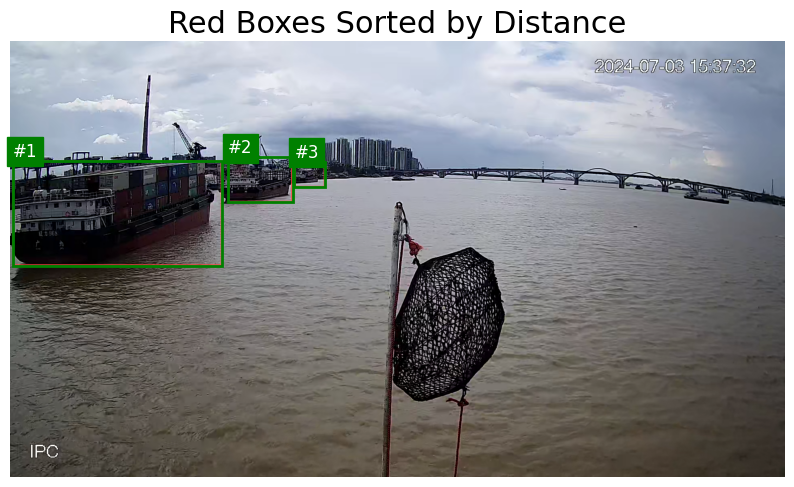

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pil

# 加载图像
input_image = pil.open("1719992094586.png").convert('RGB')
original_image = np.array(input_image)

# 定义红色范围
lower_red = np.array([120, 0, 0])
upper_red = np.array([255, 80, 80])

# 创建红色掩码
mask = cv2.inRange(original_image, lower_red, upper_red)

# 查找红框轮廓
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 处理深度图，假设您已经有了disp_resized_np变量
depth_map = disp_resized_np

# 设置最小尺寸阈值
min_width, min_height = 30, 30  # 可以根据实际需要调整这些值

# 评估每个符合大小要求的红框的平均深度
depths = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w >= min_width and h >= min_height:  # 过滤小红框
        # 计算当前红框区域的平均深度
        red_box_depth = depth_map[y:y+h, x:x+w].mean()
        depths.append((red_box_depth, x, y, w, h))

# 按平均深度排序，距离最近的框在前，现在正确地使用视差值较大代表更近
depths_sorted = sorted(depths, key=lambda x: x[0], reverse=True)

# 可视化所有红框，并标注其顺序
plt.figure(figsize=(10, 10))
plt.imshow(original_image)
plt.title("Red Boxes Sorted by Distance", fontsize=22)

for i, box in enumerate(depths_sorted):
    x, y, w, h = box[1], box[2], box[3], box[4]
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none'))
    plt.text(x, y - 10, f'#{i+1}', color='white', fontsize=12, backgroundcolor='green')

plt.axis('off')
plt.show()
